In [1]:
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,BatchNormalization
from keras.regularizers import l2
from xgboost import XGBRegressor

try:
    import gmplot
    import googlemaps
except ImportError:
    %pip install gmplot googlemaps 
    import gmplot
    import googlemaps

In [2]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

parent_path = Path().cwd().parent  

#.env
dotenv_path = parent_path / '.env'
load_dotenv(dotenv_path=dotenv_path)

GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

#src folder 
src_path = parent_path / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import from features package
from features.distance import calc_distance
from features.gmaps import extract_gmaps_data,merge_gmaps_data
from features.time import extract_time_features
from features.geolocation import clustering

In [3]:
train_df = pd.read_csv("../data/processed/eda_processed_train.csv")
test_df = pd.read_csv("../data/processed/eda_processed_test.csv")
combine = [train_df,test_df]

print("Train:",train_df.shape)
print("Test:",test_df.shape)
train_df.head()

Train: (140965, 7)
Test: (30000, 6)


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


## Calculating Euclidean & Manhattan distance

In [4]:
for df in combine:
    df['manhattan'] = calc_distance(df,method='manhattan')
    df['euclidean'] = calc_distance(df,method='euclidean')

In [5]:
df.sample()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean
29,29,-73.953308,40.775749,-73.965858,40.758522,2015-03-14 00:18:55,3314.760477,2190.235702


## Extract Google Maps data

In [6]:
# start = 0
# interval = 10000

# #process training data in batches
# while start < len(train_df):
#     print(f"Train: Now starting with batch of the {start}'s...")
#     train = train_df.loc[start:start+interval-1]
#     train = extract_gmaps_data(train,GOOGLE_MAPS_API_KEY,test=False)
#     start+=interval

# #process test data in batches
# start = 0
# while start < len(test_df):
#     print(f"Test: Now starting with batch of the {start}'s...")
#     test = test_df.loc[start:start+interval-1]
#     test = extract_gmaps_data(test,GOOGLE_MAPS_API_KEY,test=True)
#     start += interval


In [7]:
#merging multiple gmaps csv into gmaps train and test respectively
# merge_gmaps_data()

In [8]:
#importing gmaps data
gmaps_train_data = pd.read_csv("../data/processed/gmapsdata/gmaps_train_data.csv",index_col='row_id')
gmaps_test_data = pd.read_csv("../data/processed/gmapsdata/gmaps_test_data.csv",index_col='row_id')

train_df['gmaps_distance'] = gmaps_train_data['gmaps_distance']
train_df['gmaps_duration'] = gmaps_train_data['gmaps_duration']
train_df.dropna(axis=0,inplace=True)


test_df['gmaps_distance'] = gmaps_test_data['gmaps_distance']
test_df['gmaps_duration'] = gmaps_test_data['gmaps_duration']
test_df.dropna(axis=0,inplace=True)


In [9]:
train_df.sample(5)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,manhattan,euclidean,gmaps_distance,gmaps_duration
19697,20432,-73.937187,40.759590,-73.919312,40.758690,2015-02-06 14:14:42,655.0,2090.023440,1510.548921,2009,503
95940,99336,-73.984291,40.759823,-73.987244,40.755108,2015-11-22 05:41:47,228.0,853.597855,580.941326,3989,609
112990,116991,-73.989273,40.757919,-73.979965,40.781212,2015-10-31 04:19:46,389.0,3629.126719,2709.108043,1127,254
36977,38308,-74.006149,40.717201,-73.988716,40.756760,2015-12-13 00:41:37,2408.0,6344.320419,4642.700566,5521,929
101332,104904,-73.990189,40.734360,-73.991020,40.733807,2015-11-14 18:47:52,92.0,154.066175,93.290444,15738,1479


In [10]:
test_df.sample(5)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean,gmaps_distance,gmaps_duration
18235,18235,-122.410247,37.805665,-122.441065,37.799482,2012-09-02 09:20:00,4118.932479,2796.666489,3159,610
4322,4322,-73.950264,40.771397,-73.972099,40.781612,2015-05-24 20:29:58,3567.789680,2163.573945,2335,531
9942,9942,-122.473873,37.786323,-122.457058,37.763812,2012-09-13 11:40:00,4377.750295,2910.092913,4736,851
24067,24067,-73.950211,40.775620,-73.948639,40.777740,2015-05-07 20:18:07,410.991560,270.657174,270,41
18350,18350,-73.972130,40.794262,-73.977196,40.791126,2015-11-25 04:12:59,913.042463,551.503259,709,192


sometimes there are chances that Google Maps API returns 0 distance for certain routes. Treasure Island in San Francisco has weird quirks where Google Maps fails to calculate the driving distance.

In [11]:
#Tresure Island fix
for df in combine:
    TI_df = df[df['gmaps_distance']==0].loc[df.manhattan>2000]
    #replacing them with manhattan distance
    df.loc[TI_df.index,"gmaps_distance"] = TI_df.manhattan
    #approximating gmaps_duration 
    df.loc[TI_df.index,"gmaps_duration"] = TI_df.manhattan/11.0

## Time Features

In [12]:
#add weekdays,hour,date column and drop datetime
#adding holiday column
extract_time_features(combine)
train_df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,date,holiday
0,0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,19322.0,2567.0,5,0,2015-01-09,0
1,1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2855.0,550.0,5,1,2012-09-14,0
2,2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14693.0,1876.0,7,20,2015-04-19,0
3,3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,2019.0,578.0,1,23,2012-09-03,0
4,4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2382.0,608.0,3,12,2015-01-21,0


In [13]:
train_df.columns

Index(['row_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration',
       'manhattan', 'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday',
       'hour', 'date', 'holiday'],
      dtype='object')

In [14]:
train_df.holiday.value_counts()

holiday
0    137357
1      3608
Name: count, dtype: int64

## Geolocations

In [15]:
clustering(train_df,test_df)

2025-09-28 22:24:42 [INFO] Preparing coordinates...
2025-09-28 22:24:42 [INFO] Preparing Clusters...
2025-09-28 22:25:16 [INFO] Preparing labels for cluster...
2025-09-28 22:25:16 [INFO] 
Adding cluster features to dataframes...


Number of clusters found: 7


2025-09-28 22:25:17 [INFO] 
Visualizing clusters...
2025-09-28 22:25:17 [INFO] Saved HTML Files in gmaps/...
2025-09-28 22:25:18 [INFO] 
Clustering complete!


In [24]:
train_df.columns

Index(['row_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration',
       'manhattan', 'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday',
       'hour', 'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

In [25]:
test_df.columns

Index(['row_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

<Axes: >

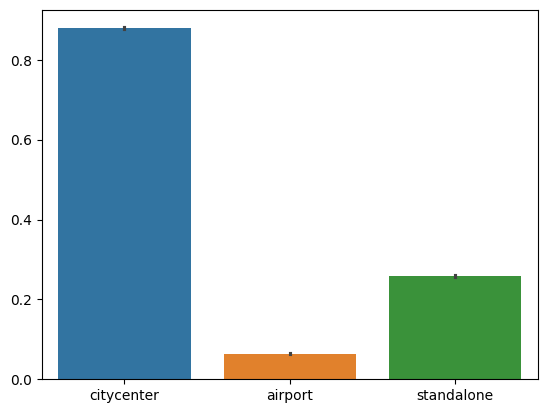

In [33]:
sns.barplot(train_df[['citycenter','airport','standalone']])